## Transmission clusters with ORF8KO
My goal is to test fitness of orf8KO by comparing transmission cluster size with ORF8KO vs. ones without. I'll do this in two ways:
1. Cluster size of missense causing early stops vs. other NS in orf8 vs. syn in ORF8
2. Cluster size of missense causing early stops vs. the one right above that.

To do this analysis, I'll use a globally representative tree, so location of a cluster will not bias results.

In [196]:
import os
from Bio import Phylo
from augur.utils import json_to_tree
import json
from Bio import SeqIO
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [3]:
os.chdir('/Users/cwagner2/Work/projects/covid/long-deletions/')

### Loading tree

In [8]:
#path to tree json
tree_file = 'data/ncov-gisaid-global_2023-04-11.json'

with open(tree_file, 'r') as f:
    tree_json = json.load(f)

#put tree in Bio.phylo format
tree = json_to_tree(tree_json)

### KO vs. NS vs. S in ORF8

In [219]:
def tabulate_names(tree):
    names = {}
    for idx, clade in enumerate(tree.find_clades()):
        if not clade.name:
            clade.name = str(idx)
        names[clade.name] = clade
    return names

def geneLocs(path):
    pos = {}
    ref = SeqIO.read(path,'gb')
    for feature in ref.features:
        if feature.type == "CDS":
            start = feature.location.start
            end = feature.location.end
            name = feature.qualifiers['gene'][0]
            pos[name] = {}
            pos[name]['end'] = end
            pos[name]['start'] = start
    return pos

def getMut(mut):
    og = mut[0]
    pos = ''.join(mut[1:-1])
    new = mut[-1]
    return og,pos,new
                    
def getMutType(muts,gene,start,end):
    if 'nuc' in muts.keys():
        all_nucs = [getMut(mut) for mut in muts['nuc']]
        nucsGene = [nuc for nuc in all_nucs if int(nuc[1])>= start and int(nuc[1])<end+1 and nuc[0] != '-' and nuc[2] != '-']
        if gene in muts.keys():
            all_ns = [getMut(mut) for mut in muts[gene]]
            nucNSList = [set(range(start - 3 + (int(mut[1])*3),start+(int(mut[1])*3))) for mut in all_ns]
            nucNS = set.union(*nucNSList)
            syn = [''.join(nuc) for nuc in nucsGene if int(nuc[1]) not in nucNS]
            stops = [''.join(mut) for mut in all_ns if mut[2] == '*' or mut[0] == '*']
            ns = [''.join(mut) for mut in all_ns if mut[2] != '*' and mut[0] != '*' and mut[2] != '-' and mut[0] != '-'] # gaps & stops are not NS
        else:
            syn = [''.join(nuc) for nuc in nucsGene]
            stops = []
            ns = []
    else:
        syn = []
        stops = []
        ns = []
    output = {}
    output['syn'] = syn
    output['nonsyn'] = ns
    output['stops'] = stops
    return output
        
def countMutType(subtree,genelocs):
    genes = genelocs.keys()
    counts = {}
    for gene in genes:
        counts[gene] = {}
        counts[gene]['syn'] = 0
        counts[gene]['nonsyn'] = 0
        counts[gene]['stop'] = 0
    for clade in subtree.find_clades():
        all_muts = {k:v for k,v in clade.branch_attrs['mutations'].items()}
        for gene in genes:
            start = genelocs[gene]['start']
            end = genelocs[gene]['end']
            muts = getMutType(all_muts,gene,start,end)
            counts[gene]['syn'] += len(muts['syn'])
            counts[gene]['nonsyn'] += len(muts['nonsyn'])
            counts[gene]['stop'] += len(muts['stops'])
    return counts

def getLeaves(subtree,gene, start,end,mutType,pos,leafs,named):
    for child in subtree.find_clades():
        if child in subtree:
            all_muts = {k:v for k,v in child.branch_attrs['mutations'].items()}
            muts = getMutType(all_muts,gene,start,end)
            #changes = [mut[0] for mut in muts[mutType]]
            locs = [int(''.join(mut[1:-1])) for mut in muts[mutType]]
            if pos not in locs:
                if child in leafs:
                    named.append(child.name)
                else:
                    getLeaves(child,gene,start,end,mutType,pos,leafs,named)
            
def getClustersFinch(subtree,gene,start,end,leafs):
    clusters = {}
    count = 1
    for clade in subtree.find_clades():
        all_muts = {k:v for k,v in clade.branch_attrs['mutations'].items()}
        muts = getMutType(all_muts,gene,start,end)
        for mutType in ['syn','nonsyn','stops']:
            if len(muts[mutType]):
                for s in muts[mutType]:
                    time = clade.node_attrs['num_date']['value']
                    clusters[count] = {}
                    clusters[count]['strains'] = [clade.name]
                    clusters[count]['mut'] = s
                    clusters[count]['mutType'] = mutType
                    pos = int(s[1:-1])
                    getLeaves(clade,gene,start,end,mutType,pos,leafs,clusters[count]['strains'])
                    times =  [names[strain].node_attrs['num_date']['value'] for strain in clusters[count]['strains']]
                    clusters[count]['persistence'] = max(times) - time
                    count += 1
    return clusters

def saveClusters(C,path):
    clusts = []
    strains = []
    muts = []
    mutTypes = []
    circs = []
    for i,j in enumerate(C.keys()):
        samples = C[j]['strains']
        mut = C[j]['mut']
        mutType = C[j]['mutType']
        circ = C[j]['persistence']
        length = len(samples)
        muts.extend([mut]*length)
        mutTypes.extend([mutType]*length)
        strains.extend(samples)
        clusts.extend([i+1]*length)
        circs.extend([circ]*length)
    df = pd.DataFrame({'strain':strains,'cluster':clusts,'mutType':mutTypes,'muts':muts,'persistence':circs})
    with open(path, 'w') as f:
        df.to_csv(f,sep='\t',index=False)
    return df
        
def getAggregate(df):
    values,counts = np.unique(df.cluster,return_counts=True)
    countDF = pd.DataFrame({'cluster':values,'clustSize':counts})
    typeDF = df[['mutType','cluster']].drop_duplicates()
    agg = df[['cluster','persistence']].drop_duplicates().merge(countDF).merge(typeDF)
    return agg
        
leafs = tree.get_terminals()
names = tabulate_names(tree)

#### Side analysis: Just checking NS/S/stop times in evolution

In [130]:
geneDict = geneLocs('sars2_ref.gb')

In [131]:
mutCounts = countMutType(tree,geneDict)

In [132]:
mutCounts

{'ORF1a': {'syn': 3533, 'nonsyn': 3737, 'stop': 7},
 'ORF1b': {'syn': 1955, 'nonsyn': 1606, 'stop': 4},
 'S': {'syn': 1201, 'nonsyn': 2027, 'stop': 3},
 'ORF3a': {'syn': 344, 'nonsyn': 736, 'stop': 5},
 'E': {'syn': 41, 'nonsyn': 65, 'stop': 0},
 'M': {'syn': 282, 'nonsyn': 172, 'stop': 0},
 'ORF6': {'syn': 67, 'nonsyn': 70, 'stop': 2},
 'ORF7a': {'syn': 150, 'nonsyn': 223, 'stop': 21},
 'ORF7b': {'syn': 42, 'nonsyn': 66, 'stop': 8},
 'ORF8': {'syn': 108, 'nonsyn': 270, 'stop': 39},
 'N': {'syn': 639, 'nonsyn': 747, 'stop': 2},
 'ORF9b': {'syn': 70, 'nonsyn': 214, 'stop': 3}}

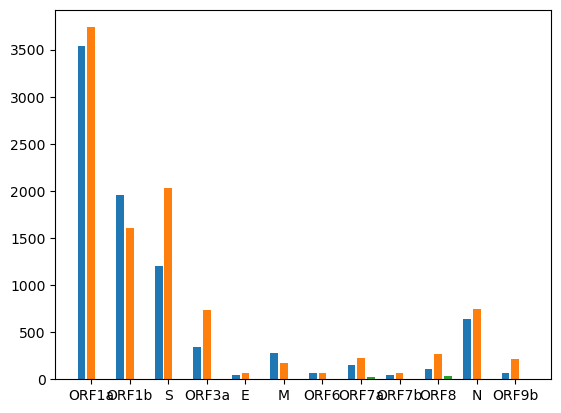

In [133]:
genes = list(mutCounts.keys())
fig,ax = plt.subplots()
pos = np.arange(0,len(genes)*4,4)
for mut,offset in zip(['syn','nonsyn','stop'],[0,1,2,]):
    positions = pos + offset
    heights = [mutCounts[gene][mut] for gene in genes]
    ax.bar(positions,heights)
    ax.set_xticks(pos+1,labels = genes)


Okay, lots of NS relative to syn, plenty of stopssss. Back to clustering.

In [134]:
orf8Clusters = getClustersFinch(tree,'ORF8',27894,28259,leafs)

In [135]:
saveClusters(orf8Clusters,'results/allTypeClusters/orf8_allType_clusters.tsv')

In [136]:
with open('results/allTypeClusters/orf8_allType_clusters.tsv','r') as f:
    clust_df = pd.read_csv(f,sep='\t')

In [137]:
clust_df

,strain,cluster,mutType,muts,persistence
0,hCoV-19/Uganda/UG052/2020,1,nonsyn,T11I,0.000000
1,hCoV-19/HongKong/HKU-200823-001/2020,2,stops,E64*,0.000000
2,hCoV-19/Cyprus/BMVUCY363/2020,3,syn,T28088A,0.000000
3,NODE_0001130,4,nonsyn,L84S,1.448017
4,hCoV-19/UnitedArabEmirates/skmc-920569110/2020,4,nonsyn,L84S,1.448017
...,...,...,...,...,...
1603,hCoV-19/Kosovo/83_S83/2023,403,nonsyn,E106Q,0.000000
1604,hCoV-19/England/PHEC-YYEP7IS/2023,404,nonsyn,S67F,0.000000
1605,hCoV-19/Montenegro/CO-01061_MNE000_1266352302/...,405,nonsyn,P93L,0.000000
1606,hCoV-19/NewZealand/23YA0548/2023,406,nonsyn,R115H,0.000000


In [140]:
clustAgg = getAggregate(clust_df)

In [251]:
def calcStatTests(df):
    nsSize1 = df[(df.mutType=='nonsyn')&(df.clustSize>1)]['clustSize']
    synSize1 = df[(df.mutType=='syn')&(df.clustSize>1)]['clustSize']
    nsSize = df[(df.mutType=='nonsyn')]['clustSize']
    synSize = df[(df.mutType=='syn')]['clustSize']
    stopSize1 = df[(df.mutType=='stops')&(df.clustSize>1)]['clustSize']
    stopSize = df[(df.mutType=='stops')]['clustSize']
    nsPerst1 = df[(df.mutType=='nonsyn')&(df.persistence>0)]['persistence']
    synPerst1 = df[(df.mutType=='syn')&(df.clustSize>1)]['clustSize']
    nsPerst = df[(df.mutType=='nonsyn')]['persistence']
    synPerst = df[(df.mutType=='syn')&(df.persistence>0)]['persistence']
    stopPerst1 = df[(df.mutType=='stops')&(df.persistence>0)]['persistence']
    stopPerst = df[(df.mutType=='stops')]['persistence']
    if len(nsSize1) and len(synSize1):
        print('ClusterSize: Nonsyn vs. Syn')
        print(st.mannwhitneyu(df[(df.mutType=='nonsyn')]['clustSize'],df[(df.mutType=='syn')]['clustSize']))
        print('\n')
    if len(nsPerst1) and len(synPerst1):
        print('Persistence: Nonsyn vs. Syn')
        print(st.mannwhitneyu(df[(df.mutType=='nonsyn')]['persistence'],df[(df.mutType=='syn')]['persistence']))
        print('\n')
    if len(stopSize):
        print('ClusterSize: Nonsyn vs. Stops')
        print(st.mannwhitneyu(df[(df.mutType=='nonsyn')]['clustSize'],df[(df.mutType=='stops')]['clustSize']))
        print('\n')   
    if len(stopPerst):
        print('Persistence: Nonsyn vs. Stops')
        print(st.mannwhitneyu(df[(df.mutType=='nonsyn')]['persistence'],df[(df.mutType=='stops')]['persistence']))
        print('\n')
    if len(stopSize):
        print('ClusterSize: Syn vs. Stops')
        print(st.mannwhitneyu(df[(df.mutType=='syn')]['clustSize'],df[(df.mutType=='stops')]['clustSize']))
        print('\n')   
    if len(stopPerst):
        print('Persistence: Syn vs. Stops')
        print(st.mannwhitneyu(df[(df.mutType=='syn')]['persistence'],df[(df.mutType=='stops')]['persistence']))
        print('\n')
        

In [246]:
def plotClusterSizeViolin(df,gene):
    ax = sns.violinplot(x='mutType', y='clustSize', data=clustAgg, cut=0, inner='box',scale='count')
    ax.set_yscale('log')
    ax.set_xlabel('')
    fig = ax.get_figure()
    fig.savefig('figs/clusterSizeViolin_'+gene+'.pdf',dpi=300,bbox_inches='tight')
    fig.clf()

In [247]:
def plotClusterSize(df,gene):
    ax = sns.stripplot(x='mutType', y='clustSize',hue='mutType', data=df, jitter=0.3,alpha=0.5)
    meds = [np.median(df[(df.clustSize>1)&(df.mutType==mutType)]['clustSize']) for mutType in df.mutType.unique()]
    ticks = np.asarray(ax.get_xticks())
    median_width=0.25
    ax.plot([ticks-median_width/2, ticks+median_width/2], [meds]*2,lw=2,color='k')
    sns.despine()
    ax.set_yscale('log')
    #ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_xlabel('Cluster type')
    ax.set_ylabel('Cluster size')
    ax.set_title(gene)
    fig = ax.get_figure()
    fig.savefig('figs/clusterSize_'+gene+'.pdf',dpi=300,bbox_inches='tight')
    fig.clf()

In [248]:
def plotClusterPersistence(df,gene):
    ax = sns.stripplot(x='mutType', y='persistence',hue='mutType', data=df, jitter=0.3,alpha=0.5)
    sns.despine()
    meds = [np.median(df[(df.persistence>0)&(df.mutType==mutType)]['persistence']) for mutType in df.mutType.unique()]
    ticks = np.asarray(ax.get_xticks())
    median_width=0.25
    ax.plot([ticks-median_width/2, ticks+median_width/2], [meds]*2,lw=2,color='k')
    #ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_xlabel('Cluster type')
    ax.set_ylabel('Years persisting')
    ax.set_title(gene)
    fig = ax.get_figure()
    fig.savefig('figs/clusterPersistence_'+gene+'.pdf',dpi=300,bbox_inches='tight')
    fig.clf()

In [249]:
def plotClusterPersistenceViolin(df,gene):
    ax = sns.violinplot(x='mutType', y='persistence', data=clustAgg, cut=0, inner='box',scale='count')
    #ax.set_yscale('log')
    ax.set_xlabel('')
    ax.set_title(gene)
    fig = ax.get_figure()
    fig.savefig('figs/clusterPersistenceViolin_'+gene+'.pdf',dpi=300,bbox_inches='tight')
    fig.clf()

In [250]:
for gene in geneDict.keys():
    print(gene)
    start = geneDict[gene]['start']
    end = geneDict[gene]['end']
    clusters = getClustersFinch(tree,gene,start,end,leafs)
    clust_df = saveClusters(clusters,'results/allTypeClusters/'+gene+'_allType_clusters.tsv')
    clustAgg = getAggregate(clust_df)
    calcStatTests(clustAgg)
    plotClusterSize(clustAgg,gene)
    plotClusterSizeViolin(clustAgg,gene)
    plotClusterPersistence(clustAgg,gene)
    plotClusterPersistenceViolin(clustAgg,gene)
    print('----------------')

ORF1a
ClusterSize: Nonsyn vs. Syn
MannwhitneyuResult(statistic=6587382.0, pvalue=0.7949910647166389)


Persistence: Nonsyn vs. Syn
MannwhitneyuResult(statistic=6582819.0, pvalue=0.728921632547157)


ClusterSize: Nonsyn vs. Stops
MannwhitneyuResult(statistic=14899.5, pvalue=0.2893521865800087)


Persistence: Nonsyn vs. Stops
MannwhitneyuResult(statistic=14864.5, pvalue=0.2948829708564943)


ClusterSize: Syn vs. Stops
MannwhitneyuResult(statistic=14115.5, pvalue=0.2846769458275321)


Persistence: Syn vs. Stops
MannwhitneyuResult(statistic=14094.5, pvalue=0.28819804421483974)




/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


----------------
ORF1b
ClusterSize: Nonsyn vs. Syn
MannwhitneyuResult(statistic=1568716.5, pvalue=0.9508432938452206)


Persistence: Nonsyn vs. Syn
MannwhitneyuResult(statistic=1567752.5, pvalue=0.9091990993192967)


ClusterSize: Nonsyn vs. Stops
MannwhitneyuResult(statistic=3672.0, pvalue=0.41600763878629643)


Persistence: Nonsyn vs. Stops
MannwhitneyuResult(statistic=3664.0, pvalue=0.4208281407173484)


ClusterSize: Syn vs. Stops
MannwhitneyuResult(statistic=4474.0, pvalue=0.4139353458689974)


Persistence: Syn vs. Stops
MannwhitneyuResult(statistic=4468.0, pvalue=0.41694197461670335)




/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


----------------
S
ClusterSize: Nonsyn vs. Syn
MannwhitneyuResult(statistic=1302304.0, pvalue=4.731456062221727e-06)


Persistence: Nonsyn vs. Syn
MannwhitneyuResult(statistic=1304087.0, pvalue=2.793672782781464e-06)


ClusterSize: Nonsyn vs. Stops
MannwhitneyuResult(statistic=3786.0, pvalue=0.33023499975465376)


Persistence: Nonsyn vs. Stops
MannwhitneyuResult(statistic=3781.5, pvalue=0.3322847563842193)


ClusterSize: Syn vs. Stops
MannwhitneyuResult(statistic=2128.5, pvalue=0.4186314676949251)


Persistence: Syn vs. Stops
MannwhitneyuResult(statistic=2124.0, pvalue=0.42265637732824646)




/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


----------------
ORF3a
ClusterSize: Nonsyn vs. Syn
MannwhitneyuResult(statistic=124152.5, pvalue=0.44582224527437087)


Persistence: Nonsyn vs. Syn
MannwhitneyuResult(statistic=124350.5, pvalue=0.48136178511449423)


ClusterSize: Nonsyn vs. Stops
MannwhitneyuResult(statistic=1438.0, pvalue=0.20369755552248836)


Persistence: Nonsyn vs. Stops
MannwhitneyuResult(statistic=1461.0, pvalue=0.22834185634774173)


ClusterSize: Syn vs. Stops
MannwhitneyuResult(statistic=686.5, pvalue=0.26596316694883304)


Persistence: Syn vs. Stops
MannwhitneyuResult(statistic=693.0, pvalue=0.2822992076040318)


----------------
E
ClusterSize: Nonsyn vs. Syn
MannwhitneyuResult(statistic=1564.0, pvalue=0.010864825420363246)


Persistence: Nonsyn vs. Syn
MannwhitneyuResult(statistic=1568.0, pvalue=0.009573730259916487)


----------------
M
ClusterSize: Nonsyn vs. Syn
MannwhitneyuResult(statistic=25083.5, pvalue=0.3405117635307683)


Persistence: Nonsyn vs. Syn
MannwhitneyuResult(statistic=25097.0, pvalue=0.3274

/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


----------------
ORF7a
ClusterSize: Nonsyn vs. Syn
MannwhitneyuResult(statistic=15220.5, pvalue=0.014411827658644957)


Persistence: Nonsyn vs. Syn
MannwhitneyuResult(statistic=15130.0, pvalue=0.008925532009950625)


ClusterSize: Nonsyn vs. Stops
MannwhitneyuResult(statistic=2471.0, pvalue=0.4193893901116936)


Persistence: Nonsyn vs. Stops
MannwhitneyuResult(statistic=2457.0, pvalue=0.46314901700602695)


ClusterSize: Syn vs. Stops
MannwhitneyuResult(statistic=1804.0, pvalue=0.1045745677673459)


Persistence: Syn vs. Stops
MannwhitneyuResult(statistic=1796.0, pvalue=0.11746376735189247)


----------------
ORF7b
ClusterSize: Nonsyn vs. Syn
MannwhitneyuResult(statistic=1255.5, pvalue=0.22642592535178785)


Persistence: Nonsyn vs. Syn
MannwhitneyuResult(statistic=1255.0, pvalue=0.22480370931038862)


ClusterSize: Nonsyn vs. Stops
MannwhitneyuResult(statistic=244.0, pvalue=0.5966134079595506)


Persistence: Nonsyn vs. Stops
MannwhitneyuResult(statistic=240.0, pvalue=0.5238648975646248)




/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


----------------
ORF9b
ClusterSize: Nonsyn vs. Syn
MannwhitneyuResult(statistic=7278.5, pvalue=0.6053161468663901)


Persistence: Nonsyn vs. Syn
MannwhitneyuResult(statistic=7259.0, pvalue=0.5724950746499604)


ClusterSize: Nonsyn vs. Stops
MannwhitneyuResult(statistic=379.5, pvalue=0.4222643365924803)


Persistence: Nonsyn vs. Stops
MannwhitneyuResult(statistic=379.5, pvalue=0.42237016394066595)


ClusterSize: Syn vs. Stops
MannwhitneyuResult(statistic=127.5, pvalue=0.3862589576098855)


Persistence: Syn vs. Stops
MannwhitneyuResult(statistic=127.5, pvalue=0.3865604322669426)




/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


----------------


<Figure size 640x480 with 0 Axes>

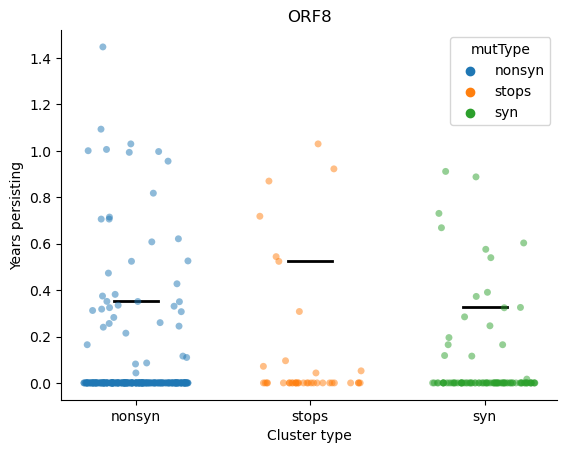

In [324]:
def calcStatTests(df,hyp):
    nsSize = df[(df.mutType=='nonsyn')]['clustSize']
    synSize = df[(df.mutType=='syn')]['clustSize']
    nsPerst = df[(df.mutType=='nonsyn')]['persistence']
    synPerst = df[(df.mutType=='syn')&(df.persistence>0)]['persistence']
    print('ClusterSize: Nonsyn vs. Syn')
    print(st.mannwhitneyu(df[(df.mutType=='nonsyn')]['clustSize'],df[(df.mutType=='syn')]['clustSize'],alternative=hyp))
    print('\n')
    print('Persistence: Nonsyn vs. Syn')
    print(st.mannwhitneyu(df[(df.mutType=='nonsyn')]['persistence'],df[(df.mutType=='syn')]['persistence'],alternative=hyp))
    print('\n')

In [327]:
with open('results/allTypeClusters/ORF7a_allType_clusters.tsv','r') as f:
    df7a = pd.read_csv(f,sep='\t')

clust7a = getAggregate(df7a)
calcStatTests(clust7a,'less')

ClusterSize: Nonsyn vs. Syn
MannwhitneyuResult(statistic=15220.5, pvalue=0.007205913829322478)


Persistence: Nonsyn vs. Syn
MannwhitneyuResult(statistic=15130.0, pvalue=0.004462766004975313)




In [328]:
with open('results/allTypeClusters/E_allType_clusters.tsv','r') as f:
    dfE = pd.read_csv(f,sep='\t')

clustE = getAggregate(dfE)
calcStatTests(clustE,'greater')

ClusterSize: Nonsyn vs. Syn
MannwhitneyuResult(statistic=1564.0, pvalue=0.005432412710181623)


Persistence: Nonsyn vs. Syn
MannwhitneyuResult(statistic=1568.0, pvalue=0.004786865129958243)




## 2. What is impact of ORF8 KO?

In [319]:
def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path[-2]

def compareKO(subtree,gene,start,end,leafs):
    clusters = {}
    count = 1
    for clade in subtree.find_clades():
        if clade.node_attrs['clade_membership']['value'] != '20I (Alpha, V1)':
            all_muts = {k:v for k,v in clade.branch_attrs['mutations'].items()}
            muts = getMutType(all_muts,gene,start,end)
            if len(muts['stops']):
                if len(muts['stops'])+len(muts['nonsyn'])==1:
                    s = muts['stops'][0]
                    clusters[count] = {}
                    clusters[count]['ko'] = {}
                    clusters[count]['noko'] = {}
                    clusters[count]['ko']['node'] = clade.name
                    clusters[count]['ko']['mut'] = s
                    strains = clade.get_terminals()
                    clusters[count]['ko']['clusterSize'] = len(strains)
                    times =  [strain.node_attrs['num_date']['value'] for strain in strains]

                    parent = get_parent(subtree,clade)
                    parentTime = parent.node_attrs['num_date']['value']
                    clusters[count]['ko']['persistence'] = max(times) - parentTime

                    otherTerm = []
                    for sib in parent.find_clades():
                        if sib in parent and sib != clade:
                            terms = sib.get_terminals()
                            otherTerm.extend(terms)
                            
                    clusters[count]['noko']['clusterSize'] = len(otherTerm)
                    newTimes = [names[strain.name].node_attrs['num_date']['value'] for strain in otherTerm]
                    clusters[count]['noko']['persistence'] = max(newTimes) - parentTime

                    count += 1
    return clusters

def compareKORedundant(subtree,gene,start,end,leafs):
    clusters = {}
    count = 1
    for clade in subtree.find_clades():
        if clade.node_attrs['clade_membership']['value'] != '20I (Alpha, V1)':
            all_muts = {k:v for k,v in clade.branch_attrs['mutations'].items()}
            muts = getMutType(all_muts,gene,start,end)
            if len(muts['stops']):
                if len(muts['stops'])+len(muts['nonsyn'])==1:
                    s = muts['stops'][0]
                    
                    parent = get_parent(subtree,clade)
                    parentTime = parent.node_attrs['num_date']['value']
                    

                    for sib in parent.find_clades():
                        if sib in parent and sib != clade:
                            
                            clusters[count] = {}
                            clusters[count]['ko'] = {}
                            clusters[count]['noko'] = {}
                            clusters[count]['ko']['node'] = clade.name
                            clusters[count]['ko']['mut'] = s
                            strains = clade.get_terminals()
                            clusters[count]['ko']['clusterSize'] = len(strains)
                            times = [strain.node_attrs['num_date']['value'] for strain in strains]
                            clusters[count]['ko']['persistence'] = max(times) - parentTime
                            
                            terms = sib.get_terminals()
                            clusters[count]['noko']['clusterSize'] = len(terms)
                            newTimes = [names[strain.name].node_attrs['num_date']['value'] for strain in terms]
                            clusters[count]['noko']['persistence'] = max(newTimes) - parentTime

                            count += 1
    return clusters

def plotSize(data,title):
    koSizes = [data[cluster]['ko']['clusterSize'] for cluster in data.keys()]
    nokoSizes = [data[cluster]['noko']['clusterSize'] for cluster in data.keys()]
    statSize, pSize = st.wilcoxon(koSizes,nokoSizes)
    fig, ax = plt.subplots()
    d = [koSizes, nokoSizes]
    ax.violinplot(d,showmedians=True, showextrema=False)
    ax.set_xticks(range(1,3),['ORF8 KO','No ORF8 KO'])
    ax.set_ylabel('Cluster Size')
    ax.set_yscale('log')
    ax.set_title(title)
    ax.text(1.3,100,'p-value = ' + str(np.round(pSize,5)))

def plotTime(data,title):
    koTime = [data[cluster]['ko']['persistence'] for cluster in data.keys()]
    nokoTime = [data[cluster]['noko']['persistence'] for cluster in data.keys()]
    statTime, pTime = st.wilcoxon(koTime,nokoTime)
    fig, ax = plt.subplots()
    d = [koTime, nokoTime]
    ax.violinplot(d,showmedians=True, showextrema=False)
    ax.set_xticks(range(1,3),['ORF8 KO','No ORF8 KO'])
    ax.set_ylabel('Years persistence')
    ax.set_title(title)
    #ax.set_yscale('log')
    ax.text(1.3,1,'p-value = ' + str(np.round(pTime,5)))

In [314]:
orf8ko = compareKO(tree,'ORF8',27894,28259,leafs)
orf8koRed = compareKORedundant(tree,'ORF8',27894,28259,leafs)

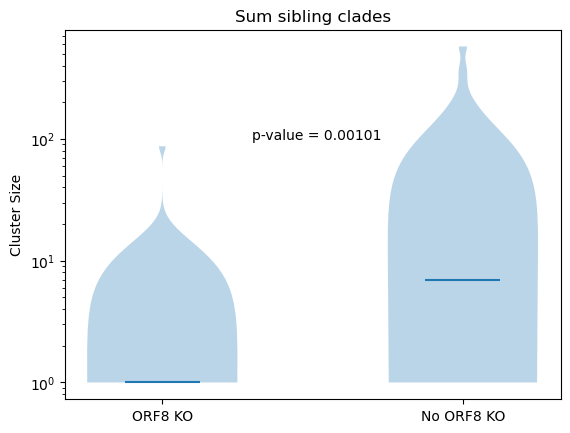

In [320]:
plotSize(orf8ko,'Sum sibling clades')

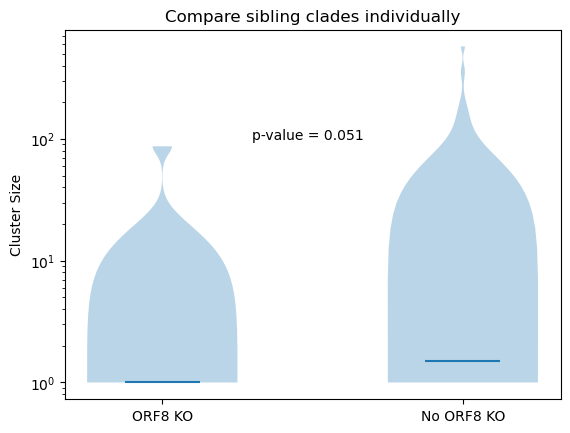

In [323]:
plotSize(orf8koRed,'Compare sibling clades individually')

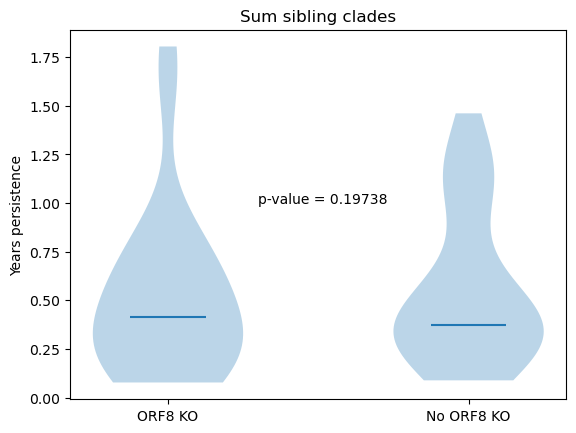

In [321]:
plotTime(orf8ko,'Sum sibling clades')

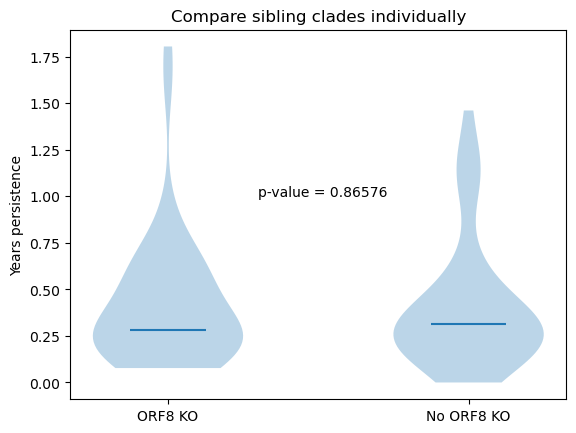

In [322]:
plotTime(orf8koRed,'Compare sibling clades individually')


Text(1.3, 1, 'p-value = 0.19738')

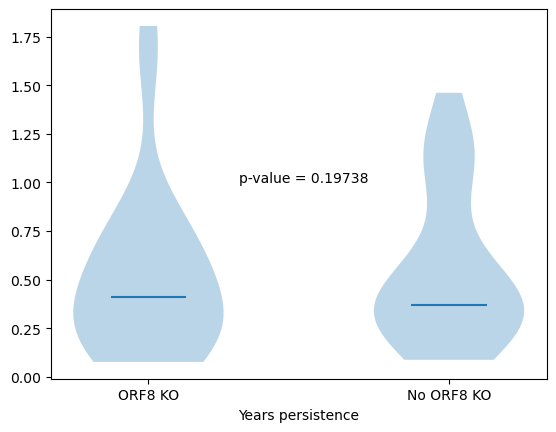